# Example for accessing research-quality sea level data through the new SLSMF API

This notebook page breaks down a sample script in R for accessing research-quality sea level data through the new SLSMF API (https://api.ioc-sealevelmonitoring.org/v2/doc). The user can modify the inputs and visualise the output sea level timeseries. 

R and Matlab scripts for accessing the sea level data for the examples mentioned in the document can be found in the folder named *Examples*.

In [19]:
# uncomment the line below to install all required packages to run R commands

#install.packages(c("httr", "dplyr", "readr", "lubridate", "ggplot2", "jsonlite", "stringr"))

In [20]:
library(httr)
library(readr)
library(dplyr)
library(lubridate)
library(ggplot2)
library(jsonlite)
library(stringr)

## User inputs section

Enter your unique *api_key* to be able to access new SLSMF API for downloading research-quality sea level data.

Instructions on obtaining an *api_key* can be found in the *API_description.md* document. 

In [21]:
# user inputs - API key

api_key <- '' # enter API key

Enter the station ID information in the code below. 
-  For the *station_ID* option below, the user can either use the IOC station code, or the SSC ID from the SLSMF catalogue: https://www.ioc-sealevelmonitoring.org/ssc/ . Using the SSC code will allow to identify the preferred sensor for the user-defined dates, for the seal level stations for which multiple sensors are attached to a single SSC code. 
-  For the *sensor* option below, the user can choose whether to harvest data from one ('one-sensor' option) or multiple ('alternate-sensor') sensors. In the case 'one-sensor' is chosen, the API will return data from only one sensor type for the entire period. The selected sensor will be the one that was preferred on the most days during the requested period, filtered by the included sensors parameter. If 'alternate-sensor' is chosen, the API will return data from multiple sensors. The preferred sensor **for each individual day** will be returned, filtered by the included sensors parameter. If no preferred sensor is available on a given day, no data will be returned for that day.
-  For the *includesensors* option below, the user can specify one or more sensors to harvest sea level data from. In combination with the above options, if 'one-sensor' is used and a single sensor is specified in the *includesensors*, the procedure for identifying a preferred sensor for the dates specified is not followed. If more than one sensors are specified in *includesensors*, then the precedure for identifying the preferred sensor will be followed as explained in the above bullet, but restricted to the sensors specified in the *includesensors* field. If *includesensors* is left blank, the code will use all available sensors for the user-defined SSC-ID.

The available *includesensor* options and their interpretation is expained in the *API_description.md* document. To check which sensor(s) are available for a station or site, the users can go to the Catalogue tab on the SLSMF page (https://www.ioc-sealevelmonitoring.org/ssc/), find the SSC-ID on the left column, and then click on the 'detail' button on the right column. The available sensors will appear in the right column of the table in the 'Linked codes' section.

In [22]:
# user inputs for station ID and sensor
station_ID <- 'pslu'
sensor <- 'one-sensor'
includesensors <- 'pwl'

In the following fields, enter the starting and ending day for requesting research-quality sea level data in the format YYYY-MM-DD.
- The *start_date* marks the beginning of the time period for which data is being requested, marking the initial date of the desired data range (this date is included in the results).
- The *end_date* is the last date of the time period for which data is being requested, marking the final date in the specified data range (this date is not included in the results). When the Timestop equals the current date, real time data will be added for the current day. The data will be from the sensor which was selected the most as preferred during the whole period, taking the include sensors field into account.

The *days_per_page* field allows the user to restrict the number of days spanning a page in order to reduce the file size per request, with a maximum of 3650 days. 
-  In case *days_per_page* is smaller or equal to the days of sea level data requested, a single request will be made to the API server and all data will be downloaded in one page.
-  Otherwise, the sea level data will be requested in chunks of data restricted to a length equal to *days_per_page* - note that if data gaps exist for a station, days with no data do not count in the *days_per_page*, and therefore it may exceed the time period defined by *days_per_page* in terms of dates.

In [23]:
# user inputs for data range dates
start_date <- '2023-01-01'  # from date, included in result. Default is 8days in the past, 'YYYY-MM-DD'
end_date <- '2023-02-01'  # until date, not included in result. Default is day of request 'YYYY-MM-DD'
days_per_page <- 15  # maximum number of days spanning a page, max 3650 days

The user inputs below control the relative sea level mean, the output time vector and format of output file. 
- *level_data*: when set to *true*, the requested data will be recalculated in reference to the mean sea level of the last ~30 days. Enabling this option (setting it to *true*) is highly recommended when requesting data from alternate sensors. This ensures consistency and prevents discrepancies or shifts in the data, when transitioning between different sensors.
- *original_stime*: set to *true* to obtain the data at the specific rate or frequency defined by the station. This means that
the data will be provided according to the station's predefined sampling rates. Setting it to *false* organizes the data into predefined time slots based on the transmission rate, essentially normalizing the data to ensure it aligns with the established intervals. This process adjusts the data to fit consistent, standardized time periods, ensuring that it is uniformly distributed according to the rate at which it was transmitted or recorded.
- *media_type*: choose the format in which you would like the requested data to be delivered. Two choices are available: receive the data in text (CSV) format, where values are separated by commas, or in JSON format, which is a structured data format commonly used for representing information in key-value pairs. If *media_type* is left empty, default is 'text/csv'.

In [24]:
# user inputs for sea level outputs
level_data <- 'true' # Level data relative to the mean sea level of ~30 days.
original_stime <- 'false' # Return the stime not corrected by sensor rate.
media_type <- 'application/json'    # choose the output format; options are either 'text/csv' or 'application/json' 

The user inputs below, provided in the form of true/false flags, control the individual quality control tools employed by the new SLSMF API. The user needs to set all tool flags to be employed in the post-processing to *true*, and all the others to *false*.
- *filter_out_of_range*: when set to *true*, this filter eliminates data points that are significantly higher or lower than the majority of the values within a specified time period. It is designed to identify and remove outliers or anomalies, ensuring that the remaining data more accurately represents typical trends and patterns for that particular time frame.
- *filter_exceeded_neighbours*: when set to *true*, this filter works by comparing the difference between adjacent sea level data points. If the difference between a specific data point and its neighboring values exceeds a defined threshold, that data point is removed. This helps eliminate abrupt, unusual fluctuations that may not align with the general trend of the surrounding data. Caution should be exercised when using this filter for tsunami events, as the initial tsunami signal may be incorrectly identified as an outlier due to exceeding the neighboring data points.
- *filter_spikes_via_median*: when set to *true*, this filter removes data points that deviate substantially from a spline-fit curve, which is a smooth, flexible curve that models the underlying trend of the data. By identifying and removing points that significantly differ from this curve, the filter helps to retain only those data points that are consistent with the overall trend, improving the accuracy and reliability of the dataset.
- *filter_flat_line*: when set to *true*, this filter addresses data gaps that appear as flat, unchanging segments in the data diagrams, typically indicating periods where no data was recorded or the data was unavailable. By removing these flat-line sections, the filter helps to clean the dataset, ensuring that only continuous, meaningful data is retained for analysis and that gaps in the data do not distort the overall trends or patterns.

A guiding document describing the quality control steps employed by the new SLSMF API service can be found in the *QC_steps_description.md* document.

In [25]:
# user inputs for post-processing flags
filter_out_of_range <- 'true' # Remove out of range values
filter_exceeded_neighbours <- 'true' # Remove exceeded neighbour values
filter_spikes_via_median <- 'true' # Remove spikes via median values
filter_flat_line <- 'true' # Remove flat line

## Data download section

The code below is used in R to download the requested sea level data based on the above user inputs. The output is either saved as *SLSMF_tg_data_pgnum.txt* or *SLSMF_tg_data_pgnum.json*, depending on the *media_type* selected above, where *pgnum* is the page number. The code reads back the downloaded data in variable named *S* before plotting.

In [26]:
# download and read research-quality sea level data

api_url <- 'https://api.ioc-sealevelmonitoring.org/v2/research/stations/'

# Calculate number of days and pages
no_of_days <- as.Date(end_date) - as.Date(start_date)
no_of_pages <- ceiling(no_of_days / days_per_page)

# Initialize an empty data frame to store sea level data
S <- data.frame()

# media format options
s1 <- "text/csv"
s2 <- "application/json"

# Loop to download data
for (i in 1:no_of_pages) {
  page <- i  # current page number requested
  
  # Building the custom URL
  if (nchar(includesensors) > 0) {
    url <- paste0(api_url, station_ID, '/sensors/', sensor, 
                  '/data?days_per_page=', days_per_page,
                  '&page=', page, 
                  '&timestart=', start_date, 
                  '&timestop=', end_date, 
                  '&includesensors[]=', includesensors, 
                  '&level_data=', level_data, 
                  '&original_stime=', original_stime, 
                  '&filter_out_of_range=', filter_out_of_range, 
                  '&filter_exceeded_neighbours=', filter_exceeded_neighbours,
                  '&filter_spikes_via_median=', filter_spikes_via_median, 
                  '&filter_flat_line=', filter_flat_line)
  } else {
    url <- paste0(api_url, station_ID, '/sensors/', sensor, 
                  '/data?days_per_page=', days_per_page,
                  '&page=', page, 
                  '&timestart=', start_date, 
                  '&timestop=', end_date, 
                  '&level_data=', level_data, 
                  '&original_stime=', original_stime, 
                  '&filter_out_of_range=', filter_out_of_range, 
                  '&filter_exceeded_neighbours=', filter_exceeded_neighbours,
                  '&filter_spikes_via_median=', filter_spikes_via_median, 
                  '&filter_flat_line=', filter_flat_line)
  }
  # Downloading the data
  message(paste('Downloading page', page, '/', no_of_pages, 'of the data requested in '), print(media_type),' format')
    if (str_equal(s2, media_type) > 0) {
        response <- GET(url, add_headers(`X-Api-Key` = api_key, Accept = media_type))
        } else {
        response <- GET(url, add_headers(`X-Api-Key` = api_key, Accept = 'text/csv'))
        }
  # Writing the output file(s)
    if (str_equal(s2, media_type) > 0) {
        writeLines(content(response, "text", encoding = "UTF-8"), con = paste0('SLSMF_tg_data_pg', page, '.json'))
        } else {
        writeLines(content(response, "text", encoding = "UTF-8"), con = paste0('SLSMF_tg_data_pg', page, '.txt'))
        }
  # Read the tables back
  if (i == 1) {
      if (str_equal(s2, media_type) > 0) {
          tmp <- fromJSON(paste0('SLSMF_tg_data_pg', page, '.json'), simplifyVector = TRUE)
          S <- as.data.frame(tmp["data"])
          } else {
          S <- read_tsv(paste0('SLSMF_tg_data_pg', page, '.txt'), skip = 2)
          }
  } else {
      if (str_equal(s2, media_type) > 0) {
          tmp <- fromJSON(paste0('SLSMF_tg_data_pg', page, '.json'), simplifyVector = TRUE)
          S <- bind_rows(S, as.data.frame(tmp["data"]))
          } else {
          tmp <- read_tsv(paste0('SLSMF_tg_data_pg', page, '.txt'), skip = 2)
          S <- bind_rows(S, tmp)
          }
  }
}

[1] "application/json"


[1] "application/json"


[1] "application/json"


## Data plotting section

The code below is used in R to plot the requested sea level data based on the above user inputs. The plot of the downloaded sea level time series should appear below the code.

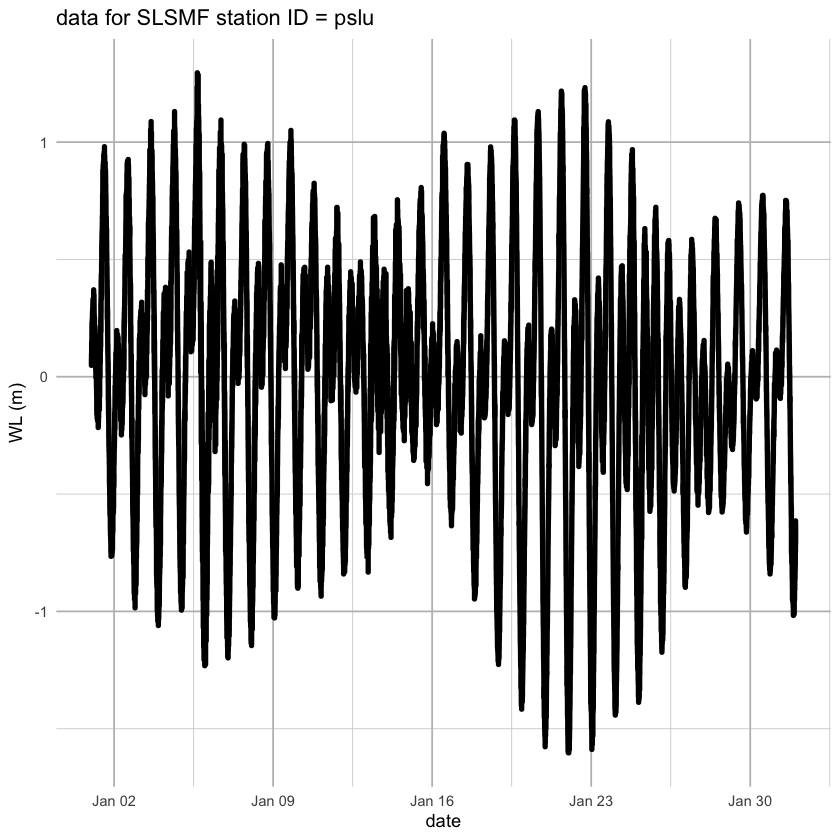

In [27]:
# plot the data
if (str_equal(s2, media_type) > 0) {
    S$data.stime <- as.POSIXct(S$data.stime,format="%Y-%m-%d %H:%M:%S",tz="UTC")
    ggplot() +
    # Plot the S.data.stime and S.data.slevel
    geom_line(data = S, aes(x = data.stime, y = data.slevel), color = "black", linewidth = 1.5) +
    # Add legend and labels
    labs(
    title = paste("data for SLSMF station ID =", station_ID),
    x = "date",
    y = "WL (m)"
  ) +
    # Enable grid
    theme_minimal() +
    theme(panel.grid.major = element_line(color = "grey"),
          panel.grid.minor = element_line(color = "lightgrey"))
} else {
    ggplot() +
    # Plot the S.stime and S.slevel
    geom_line(data = S, aes(x = stime, y = slevel), color = "black", linewidth = 1.5) +
    # Add legend and labels
    labs(
        title = paste("data for SLSMF station ID =", station_ID),
        x = "date",
        y = "WL (m)"
    ) +
    # Enable grid
    theme_minimal() +
    theme(panel.grid.major = element_line(color = "grey"),
          panel.grid.minor = element_line(color = "lightgrey"))
}